<a href="https://colab.research.google.com/github/samarth-kashyap/NotebookTemplates/blob/main/eig_sample1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install numpyro

     |████████████████████████████████| 264 kB 5.4 MB/s 


In [15]:
! pip install py3nj

  Created wheel for py3nj: filename=py3nj-0.1.2-cp37-cp37m-linux_x86_64.whl size=101180 sha256=fb445af585bcbc53a80f65a080bb013fa7fa040cbab6a77a12d6bcfd1ad64e12
  Stored in directory: /root/.cache/pip/wheels/dd/e8/bb/9e13947719ac9d5a9191f7d788a5025a377d6d1cb1dd1bd330
Successfully built py3nj


In [19]:
import matplotlib.pyplot as plt
from jax import random, vmap
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import numpy as np
import py3nj
import os

NAX = np.newaxis

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SA, HMC
from numpyro.infer import init_to_sample, init_to_value
from numpyro import handlers

plt.style.use('bmh')
#numpyro.set_platform("cpu")

from scipy.integrate import simps
from jax.numpy import trapz

In [17]:
def w3j_vecm(l1, l2, l3, m1, m2, m3):
    """Computes the wigner-3j symbol for given l1, l2, l3, m1, m2, m3.

    Inputs:
    -------
    l1, l2, l3 - int
    m1, m2, m3 - np.ndarray(ndim=1, dtype=np.int32)

    Returns:
    --------
    wigvals - np.ndarray(ndim=1, dtype=np.float32)
    """
    l1 = int(2*l1)
    l2 = int(2*l2)
    l3 = int(2*l3)
    m1 = 2*m1
    m2 = 2*m2
    m3 = 2*m3
    wigvals = py3nj.wigner3j(l1, l2, l3, m1, m2, m3)
    return wigvals


def eig_mcmc_func(w1=None, w3=None, w5=None):
    return  get_eigs(create_supermatrix(w1, w3, w5))/2./omega0
    

#def create_supermatrix(wsr_slope):
def create_supermatrix(w1, w3, w5):
    integrand1 = 0.1*Tsr[0, :] * (1 + w1)
    integrand3 = 0.1*Tsr[1, :] * (1 + w3)
    integrand5 = 0.1*Tsr[2, :] * (1 + w5)
    integral1 = trapz(integrand1, x=r)
    integral3 = trapz(integrand3, x=r)
    integral5 = trapz(integrand5, x=r)
    prod_gamma1 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma3 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma5 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    wpi = (wigvals[:, 0]*integral1*prod_gamma1 + 
           wigvals[:, 1]*integral3*prod_gamma3 +
           wigvals[:, 2]*integral5*prod_gamma5)
    diag = 8*np.pi*omega0*wpi
    supmat = jnp.diag(diag)
    return supmat

def get_eigs(mat):
    eigvals, eigvecs = jnp.linalg.eigh(mat)
    return eigvals

def gamma(ell):
    return jnp.sqrt((2*ell+1)/4./np.pi)

def minus1pow_vecm(num):
    modval = num % 2
    retval = np.zeros_like(modval)
    retval[modval == 1] = -1
    retval[modval == 0] = 1
    return retval

In [9]:
rm *.dat

rm: cannot remove '*.dat': No such file or directory


In [12]:
!wget ftp://ftp.tifr.res.in/g.samarth/eig1/U3672.dat
!wget ftp://ftp.tifr.res.in/g.samarth/eig1/V3672.dat
!wget ftp://ftp.tifr.res.in/g.samarth/eig1/r.dat
!wget ftp://ftp.tifr.res.in/g.samarth/eig1/Tsr.npy

--2021-11-22 13:07:11--  ftp://ftp.tifr.res.in/g.samarth/eig1/U3672.dat
           => ‘U3672.dat’
Resolving ftp.tifr.res.in (ftp.tifr.res.in)... 158.144.1.37, 2406:f00:1:1::70
Connecting to ftp.tifr.res.in (ftp.tifr.res.in)|158.144.1.37|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /g.samarth/eig1 ... done.
==> SIZE U3672.dat ... 60000
==> PASV ... done.    ==> RETR U3672.dat ... done.
Length: 60000 (59K) (unauthoritative)

U3672.dat           100%[===================>]  58.59K   113KB/s    in 0.5s    

2021-11-22 13:07:17 (113 KB/s) - ‘U3672.dat’ saved [60000]

--2021-11-22 13:07:17--  ftp://ftp.tifr.res.in/g.samarth/eig1/V3672.dat
           => ‘V3672.dat’
Resolving ftp.tifr.res.in (ftp.tifr.res.in)... 158.144.1.37, 2406:f00:1:1::70
Connecting to ftp.tifr.res.in (ftp.tifr.res.in)|158.144.1.37|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I .

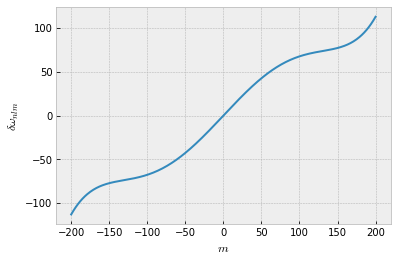

In [20]:
r = np.loadtxt('r.dat')
U = np.loadtxt('U3672.dat')
V = np.loadtxt('V3672.dat')
Tsr = np.load('Tsr.npy')

rmin, rmax = 0.3, 1.0
rmin_idx = np.argmin(abs(r - rmin))
rmax_idx = np.argmin(abs(r - rmax)) + 1

r = r[rmin_idx:rmax_idx]
U = U[rmin_idx:rmax_idx]
V = V[rmin_idx:rmax_idx]

r = jnp.asarray(r)
U = jnp.asarray(U)
V = jnp.asarray(V)
Tsr = jnp.asarray(Tsr)

n1, n2 = 0, 0
ell1, ell2 = 200, 200
ell = min(ell1, ell2)
nu0 = 4741.

Msol = 1.989e33
Rsol = 6.956e10
B0 = 10.e5
OM = jnp.sqrt(4*np.pi*Rsol*B0**2/Msol)
nu0 /= OM*1e6
omega0 = 2*jnp.pi*nu0

s_arr = jnp.array([1., 3., 5.])
m = jnp.arange(-ell, ell+1)
wigvals = np.zeros((2*ell+1, len(s_arr)))
for i in range(len(s_arr)):
    wigvals[:, i] = w3j_vecm(ell1, s_arr[i], ell2, -m, 0*m, m)
    
wigvals = jnp.asarray(wigvals)
w1t, w3t, w5t = 10.51, .43, .175
eigvals_true = get_eigs(create_supermatrix(w1t, w3t, w5t))/2/omega0
eigvals_sigma = np.ones_like(eigvals_true)*0.015
eigvals_sigma = jnp.asarray(eigvals_sigma)

plt.figure()
plt.plot(m, eigvals_true)
plt.xlabel('$m$')
plt.ylabel('$\delta\omega_{nlm}$')
plt.show()



In [29]:
def model():
    # setting min and max value to be .2*true and 2.0*true
    w1min, w1max = .2*abs(w1t), 3.*abs(w1t)
    w3min, w3max = .2*abs(w3t), 3.*abs(w3t)
    w5min, w5max = .2*abs(w5t), 3.*abs(w5t)
    
    w1 = numpyro.sample('w1', dist.Uniform(w1min, w1max))
    w3 = numpyro.sample('w3', dist.Uniform(w3min, w3max))
    w5 = numpyro.sample('w5', dist.Uniform(w5min, w5max))
    
    eig_sample = eig_mcmc_func(w1=w1, w3=w3, w5=w5)
    eig_sample -= eigvals_true
    eig_sample /= eigvals_sigma
    numpyro.factor('obs', dist.Normal(0.0, 1.0).log_prob(eig_sample))
    return None

In [30]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(int(15 + 10*np.random.rand()))
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
#kernel = NUTS(model, adapt_step_size=True)
#mcmc = MCMC(kernel, num_warmup=10, num_samples=20, num_chains=1)

kernel = SA(model, adapt_state_size=130)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=1750, num_chains=1)
model_init = numpyro.infer.util.initialize_model(rng_key_, model, model_args=())

mcmc.run(rng_key_, extra_fields=('potential_energy',))
mcmc.print_summary()
print(f"w1_true = {w1t}\n" +
      f"w3_true = {w3t}\n" +
      f"w5_true = {w5t}")

sample: 100%|██████████| 3250/3250 [00:56<00:00, 57.50it/s, acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        w1     10.51      0.00     10.51     10.51     10.51   1810.00      1.00
        w3      0.43      0.00      0.43      0.43      0.43   1801.03      1.00
        w5      0.17      0.00      0.18      0.17      0.18   1149.54      1.00

Number of divergences: 0
w1_true = 10.51
w3_true = 0.43
w5_true = 0.175


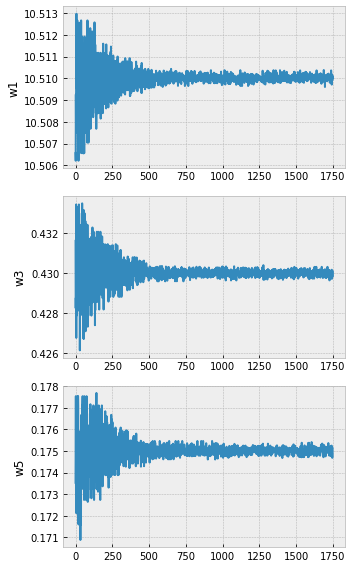

In [31]:
samples_1 = mcmc.get_samples()
fig, axs = plt.subplots(nrows=len(samples_1.keys()), ncols=1, figsize=(5, 8))
axs = axs.flatten()
count = 0
for key in samples_1.keys():
    axs[count].plot(samples_1[f'{key}'])
    axs[count].set_ylabel(f'{key}')
    count += 1
plt.tight_layout()